In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import openpyxl
import os


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
processed_dir = TOP + 'data/processed/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [36]:
elsie = pd.read_excel(raw_dir+'CCD-Batch-Search_2022-03-28_09_38_13.xlsx', sheet_name = 'Main Data')

In [37]:
elsie.shape

(457, 23)

In [44]:
elsie = elsie[(elsie['SMILES'] != ' ') & (~elsie['SMILES'].str.contains('\*'))]

In [45]:
elsie.shape

(416, 23)

In [46]:
elise_dict ={k:Chem.MolFromSmiles(v) for k,v in zip(elsie['DTXSID'],elsie['SMILES'])}

In [48]:
#elise_dict

In [49]:
elise_dict_v1 = {k: v for k, v in elise_dict.items() if v is not None}

In [50]:
elise_dict_smi ={k:v for k,v in zip(elsie['DTXSID'],elsie['SMILES']) if v is not None}

In [51]:
len(elise_dict_v1)

416

In [52]:
#elise_dict_smi

FDA COC listing

In [53]:
fda_coc = pd.read_excel(raw_dir+'FDA_COC.xlsx', sheet_name = 'FDA_COC')

fda_coc = fda_coc.iloc[:, :5]


In [54]:
fda_dict = {}
for i,group in fda_coc.groupby('COC'):
    key = [name for name in group['COC'] if name!=' '][0]
    value = set(group['SMARTS'])
    fda_dict[key]=value

In [55]:
fda_smarts = {k:[Chem.MolFromSmarts(e) for e in v] for k,v in fda_dict.items()}
fda_sms = {k:list(filter(None, fda_smarts[k])) for k,v in fda_smarts.items() }

RDKit ERROR: [15:40:53] SMARTS Parse Error: syntax error while parsing: [$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])_100])[#1,#6;!$([CX3](=[OX1])[#1,#6])_100 show full SMARTS
RDKit ERROR: [15:40:53] SMARTS Parse Error: Failed parsing SMARTS '[$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])_100])[#1,#6;!$([CX3](=[OX1])[#1,#6])_100 show full SMARTS' for input: '[$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])])[#1,#6;!$([CX3](=[OX1])[#1,#6]) show full SMARTS'
RDKit ERROR: [15:40:53] SMARTS Parse Error: syntax error while parsing: [OX2]1[CX4]([#1,c,$([CH3])_100,$([CH2][CH3])_101,$([CH2][CH2][CH3])_102,$([CH]([CH3])[CH3])_103
RDKit ERROR: [15:40:53] SMARTS Parse Error: Failed parsing SMARTS '[OX2]1[CX4]([#1,c,$([CH3])_100,$([CH2][CH3])_101,$([CH2][CH2][CH3])_102,$([CH]([CH3])[CH3])_103' for input: '[OX2]1[CX4]([#1,c,$([CH3]),$([CH2][CH3]),$([CH2][CH2][CH3]),$([CH]([CH3])[CH3])'


In [56]:
#fda_sms

Inorganic filter functions

In [57]:
def has_metal_atom(smiles):
    metal_dict = {'Na': 11 , 'Mg': 12, 'Si': 14, 'K':19, 'Ca':20, 'Mn':25, 'Fe':26, 'Cu':29, 'Zn':30, 'Co':27, 'Ni':28, 'As': 33, 'Cr':24, 'Hg':80, 'Pb':82, 'V':23, 'Al':13, 'Ag':47, 'Cd':48, 'B':5, 'Ti': 22, 'Se': 34, 'Sn': 50, 'Sb':51, 'Be': 4, 'Zr': 40, 'Nb': 41, 'Mo': 42, 'Te':52, 'Ba':56, 'W':74, 'Au': 79, 'Bi': 83}
    essential_metal_dict = {'Na': 11 , 'K':19,'Mg': 12,  'Ca':20, 'Fe':26,  'Mn':25, 'Co':27, 'Cu':29, 'Zn':30, 'Mo': 42}
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(atom for atom in mol.GetAtoms() if atom.GetAtomicNum() in list(metal_dict.values()))

In [58]:
def metal_ions(smiles):
    essential_metal = ['[Na+]', '[K+]', '[Mg++]',  '[Ca++]', '[Fe+3]',  '[Mn++]', '[Co+]', '[Cu++]', '[Zn++]', '[Mo++]']
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(mol.HasSubstructMatch(Chem.MolFromSmarts(e)) for e in essential_metal)

In [59]:
def P_inorg(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return mol.HasSubstructMatch(Chem.MolFromSmarts('[OH]P(=[O])([OH])[OH]'))

Genotoxicity alerts

In [60]:
genetox = pd.read_excel(raw_dir+'genetox_structural_alerts_201021.xlsx', sheet_name = 'Final')
genetox = genetox.drop_duplicates(['SMARTS'], keep = 'first')

In [61]:
genetox_dict = {}
for i,group in genetox.groupby('ID'):
    key = [name for name in group['ID'] if name!=' '][0]
    value = set(group['SMARTS'])
    genetox_dict[key]=value

In [62]:
genetox_smarts = {k:[Chem.MolFromSmarts(e) for e in v] for k,v in genetox_dict.items()}
genetox_smarts = {k: list(filter(None, genetox_smarts[k])) for k,v in genetox_smarts.items()}

RDKit ERROR: [15:41:25] SMARTS Parse Error: syntax error while parsing: [$([CX4]([$([OH])_100,$(C=O)_101,$([NX3])_102])([!F!Cl!Br!I!C])([*!$(C)_103])[CH2][F,Cl,Br,I])_104,$ show full SMARTS
RDKit ERROR: [15:41:25] SMARTS Parse Error: Failed parsing SMARTS '[$([CX4]([$([OH])_100,$(C=O)_101,$([NX3])_102])([!F!Cl!Br!I!C])([*!$(C)_103])[CH2][F,Cl,Br,I])_104,$ show full SMARTS' for input: '[$([CX4]([$([OH]),$(C=O),$([NX3])])([!F!Cl!Br!I!C])([*!$(C)])[CH2][F,Cl,Br,I]),$ show full SMARTS'
RDKit ERROR: [15:41:25] SMARTS Parse Error: syntax error while parsing: NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]
RDKit ERROR: [15:41:25] SMARTS Parse Error: Failed parsing SMARTS 'NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]' for input: 'NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]'
RDKit ERROR: [15:41:25] SMARTS Parse Error: syntax error while parsing: [a!r0][$([NH2])_100;!$([NH2]aa[$(C(F)(F)F)_101,$(S(=O)(=O)[NX3]([#6,#1])[#6,#1])_102,$(S(=O) show full SMARTS
RDKit ERROR: [15:41:25] SMARTS Par

In [63]:
def inorgs(df):
    df['metal_salts'] = [metal_ions(x) for x in df['SMILES']]
    df['inorgs'] = [has_metal_atom(x) for x in df['SMILES']]
    df['inorgP'] = [P_inorg(x) for x in df['SMILES']]
    return df

In [64]:
elsie = inorgs(elsie)

<ipython-input-63-244e5973cabc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['metal_salts'] = [metal_ions(x) for x in df['SMILES']]
<ipython-input-63-244e5973cabc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inorgs'] = [has_metal_atom(x) for x in df['SMILES']]
<ipython-input-63-244e5973cabc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [65]:
def inorg_filter(df):
    inorg_filter = []
    for x, y, z in list(zip(df['metal_salts'], df['inorgs'], df['inorgP'])):
        if x is True:
            inorg_filter.append('metal_salt')
        elif x is False and y is True:
            inorg_filter.append('inorganic')
        elif z is True:
            inorg_filter.append('inorganic')
        else:
            inorg_filter.append('TTC_NA')
    df['inorg_filter'] = inorg_filter
    return df

In [80]:
elsie = inorg_filter(elsie)

<ipython-input-65-9413b3d1b03f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inorg_filter'] = inorg_filter


In [81]:
elsie

,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,INCHIKEY,IUPAC_NAME,SMILES,QSAR_READY_SMILES,ATMOSPHERIC_HYDROXYLATION_RATE_(AOH)_CM3/MOLECULE*SEC_OPERA_PRED,...,OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED,MELTING_POINT_DEGC_OPERA_PRED,OPERA_PKAA_OPERA_PRED,OPERA_PKAB_OPERA_PRED,VAPOR_PRESSURE_MMHG_OPERA_PRED,WATER_SOLUBILITY_MOL/L_OPERA_PRED,metal_salts,inorgs,inorgP,inorg_filter
0,DTXSID2066561,DSSTox_Substance_Id,DTXSID2066561,Fenozan,20170-32-5,WPMYUUITDBHVQZ-UHFFFAOYSA-N,"3-(3,5-Di-tert-butyl-4-hydroxyphenyl)propanoic...",CC(C)(C)C1=CC(CCC(O)=O)=CC(=C1O)C(C)(C)C,CC(C)(C)C1=CC(CCC(O)=O)=CC(=C1O)C(C)(C)C,0.0,...,4.57702,155.655,,,0.0,0.000058,False,False,False,TTC_NA
1,DTXSID3067815,DSSTox_Substance_Id,DTXSID3067815,"(2,4,6-Trioxo-1,3,5-triazine-1,3,5(2H,4H,6H)-t...",34137-09-2,MQRCHVBRBGNZGJ-UHFFFAOYSA-N,"(2,4,6-Trioxo-1,3,5-triazinane-1,3,5-triyl)tri...",CC(C)(C)C1=CC(CCC(=O)OCCN2C(=O)N(CCOC(=O)CCC3=...,CC(C)(C)C1=CC(CCC(=O)OCCN2C(=O)N(CCOC(=O)CCC3=...,,...,,168.793,,,0.0,,False,False,False,TTC_NA
2,DTXSID3026564,DSSTox_Substance_Id,DTXSID3026564,Triethylene glycol bis(2-ethylhexanoate),94-28-0,FRQDZJMEHSJOPU-UHFFFAOYSA-N,"[(Ethane-1,2-diyl)bis(oxy)ethane-2,1-diyl] bis...",CCCCC(CC)C(=O)OCCOCCOCCOC(=O)C(CC)CCCC,CCCCC(CC)C(=O)OCCOCCOCCOC(=O)C(CC)CCCC,0.0,...,3.59995,-20.3986,,,0.0,0.000039,False,False,False,TTC_NA
3,DTXSID4024696,DSSTox_Substance_Id,DTXSID4024696,Butyl methacrylate,97-88-1,SOGAXMICEFXMKE-UHFFFAOYSA-N,Butyl 2-methylprop-2-enoate,CCCCOC(=O)C(C)=C,CCCCOC(=O)C(C)=C,0.0,...,2.8773,-74.8169,,,2.12457,0.005684,False,False,False,TTC_NA
4,DTXSID9021847,DSSTox_Substance_Id,DTXSID9021847,Diphenyl oxide,101-84-8,USIUVYZYUHIAEV-UHFFFAOYSA-N,"1,1'-Oxydibenzene",O(C1=CC=CC=C1)C1=CC=CC=C1,O(C1=CC=CC=C1)C1=CC=CC=C1,0.0,...,4.13044,27.1481,,,0.019946,0.000133,False,False,False,TTC_NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,DTXSID5042328,DSSTox_Substance_Id,DTXSID5042328,Dimethyl (p-methoxybenzylidene)malonate,7443-25-6,JMFYZMAVUHNCPW-UHFFFAOYSA-N,Dimethyl [(4-methoxyphenyl)methylidene]propane...,COC(=O)C(=CC1=CC=C(OC)C=C1)C(=O)OC,COC(=O)C(=CC1=CC=C(OC)C=C1)C(=O)OC,0.0,...,2.43083,46.0152,,,0.000063,0.001334,False,False,False,TTC_NA
452,DTXSID40864845,DSSTox_Substance_Id,DTXSID40864845,"4H-3,1-Benzoxazin-4-one, 2,2'-(1,4-phenylene)bis-",18600-59-4,BBITXNWQALLODC-UHFFFAOYSA-N,"2,2'-(1,4-Phenylene)di(4H-3,1-benzoxazin-4-one)",O=C1OC(=NC2=CC=CC=C12)C1=CC=C(C=C1)C1=NC2=CC=C...,O=C1OC(=NC2=CC=CC=C12)C1=CC=C(C=C1)C1=NC2=CC=C...,0.0,...,3.06757,144.209,,,0.0,0.0,False,False,False,TTC_NA
453,DTXSID4027286,DSSTox_Substance_Id,DTXSID4027286,1-Docosanol,661-19-8,NOPFSRXAKWQILS-UHFFFAOYSA-N,Docosan-1-ol,CCCCCCCCCCCCCCCCCCCCCCO,CCCCCCCCCCCCCCCCCCCCCCO,0.0,...,9.35723,72.305,,,0.0,0.0,False,False,False,TTC_NA
454,DTXSID0038883,DSSTox_Substance_Id,DTXSID0038883,"Phenol, 4,4',4''-(1-methyl-1-propanyl-3-yliden...",1843-03-4,PRWJPWSKLXYEPD-UHFFFAOYSA-N,"4,4',4''-(Butane-1,1,3-triyl)tris(2-tert-butyl...",CC(CC(C1=CC(=C(O)C=C1C)C(C)(C)C)C1=CC(=C(O)C=C...,CC(CC(C1=CC(=C(O)C=C1C)C(C)(C)C)C1=CC(=C(O)C=C...,0.0,...,10.0003,186.464,,,0.0,0.0,False,False,False,TTC_NA


In [82]:
def alert_match(mydict, alert_dict , label = 'COC', label2 = None):
    alert_matches = {x:[k for k, v in alert_dict.items() if any([y.HasSubstructMatch(e) for e in v])] for x,y in mydict.items()}
    alert_matches_df = pd.DataFrame(list(alert_matches.items()), columns = ['DTXSID', label])
    alert_lst = []
    for x in alert_matches_df[label]:
        if x !=[]:
            alert_lst.append(1)
        else:
            alert_lst.append(0)
    alert_matches_df[label2] = alert_lst
    return alert_matches_df

In [83]:
fda_coc_df = alert_match(elise_dict_v1, fda_sms, label = 'COC')

In [84]:
elsie_coc = pd.merge(elsie, fda_coc_df, on = 'DTXSID', how = 'left')

In [85]:
#elsie_coc

In [86]:
genetox_df = alert_match(elise_dict_v1, genetox_smarts, label = 'Genetox_Alert', label2 = 'Genetox_alert')

In [87]:
elsie_coc_genetox = pd.merge(elsie_coc, genetox_df, on = 'DTXSID', how = 'left')

In [95]:
elsie_coc_genetox = elsie_coc_genetox[['DTXSID',
                                                         'PREFERRED_NAME',
                                                                  'CASRN',
                                                               'INCHIKEY',
                                                             'IUPAC_NAME',
                                                                 'SMILES',
                                                      'QSAR_READY_SMILES','metal_salts',
                                                                 'inorgs',
                                                                 'inorgP',
                                                           'inorg_filter',
                                                                    'COC',
                                                                     None,
                                                          'Genetox_Alert',
                                                          'Genetox_alert']]

In [98]:
elsie_coc_genetox.columns = ['DTXSID',    'PREFERRED_NAME',             'CASRN',
                'INCHIKEY',        'IUPAC_NAME',            'SMILES',
       'QSAR_READY_SMILES',       'metal_salts',            'inorgs',
                  'inorgP',      'inorg_filter',               'COC',
                      'COC_Alerts',     'Genetox_Alert',     'Genetox_alert']

In [99]:
def final_assignment(df, label = 'final_TTC_category'):
    final_outcome = []
    for a,b,c in list(zip(df['inorg_filter'], df['COC_Alerts'], df['Genetox_alert'] )):
        if a == 'inorganic':
            final_outcome.append('inorganic')
        elif (a != 'inorganic') & (b == 1):
            final_outcome.append('COC')
        elif (a != 'inorganic') & (b == 'None') | (b == 0) & (c == 1):
            final_outcome.append('Genotoxicity Alert')
        elif (a != 'inorganic') & (b == 'None') | (b == 0) & (c == 0):
            final_outcome.append('Cramer_class_applicable')
    df[label] = final_outcome
    return df

In [100]:
final_elsie = final_assignment(elsie_coc_genetox, label ='final_TTC_category' )

<ipython-input-99-4c6b6fcb45b8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = final_outcome


In [105]:
final_elsie.final_TTC_category.value_counts(dropna = True)

Cramer_class_applicable    226
Genotoxicity Alert         139
inorganic                   27
COC                         24
Name: final_TTC_category, dtype: int64

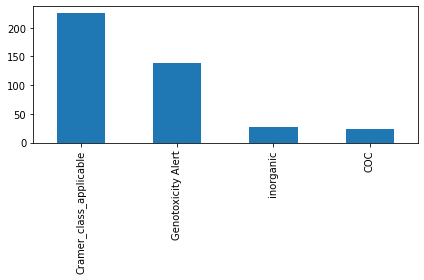

In [102]:
final_elsie.final_TTC_category.value_counts().plot.bar()
plt.tight_layout()
plt.savefig(figures_dir+ 'ELSIE_new_TTC_category_counts_310322.png')

In [103]:
writer = pd.ExcelWriter(interim_dir+ 'ELSIE_030222.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

final_elsie.to_excel(writer, sheet_name = 'final')



writer.save()